In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator

In [2]:
CHECKPOINTS = ["models/sam_vit_h_4b8939.pth", "models/sam_vit_l_0b3195.pth", "models/sam_vit_b_01ec64.pth"]
MODEL_TYPES = ["vit_h", "vit_l", "vit_b"]

IMAGE_PATHS = ["FoodSeg103/00000002.jpg", "FoodSeg103/00000003.jpg", "FoodSeg103/00000004.jpg"]
DEVICE = "cuda"

In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x["area"]), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((sorted_anns[0]["segmentation"].shape[0], sorted_anns[0]["segmentation"].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann["segmentation"]
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

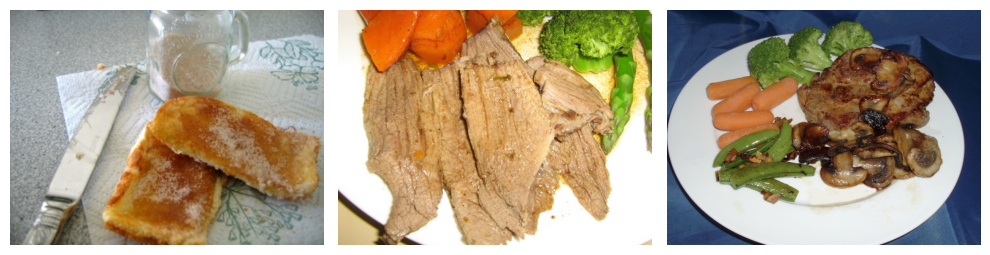

In [4]:
images = []
plt.figure(figsize=(10, 3))
for idx, image in enumerate(IMAGE_PATHS):
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    plt.subplot(1, 3, idx + 1)
    plt.imshow(image)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [5]:
sam = sam_model_registry[MODEL_TYPES[0]](checkpoint=CHECKPOINTS[0])
# sam.to(device=DEVICE)

In [6]:
mask_generator = SamAutomaticMaskGenerator(model=sam)

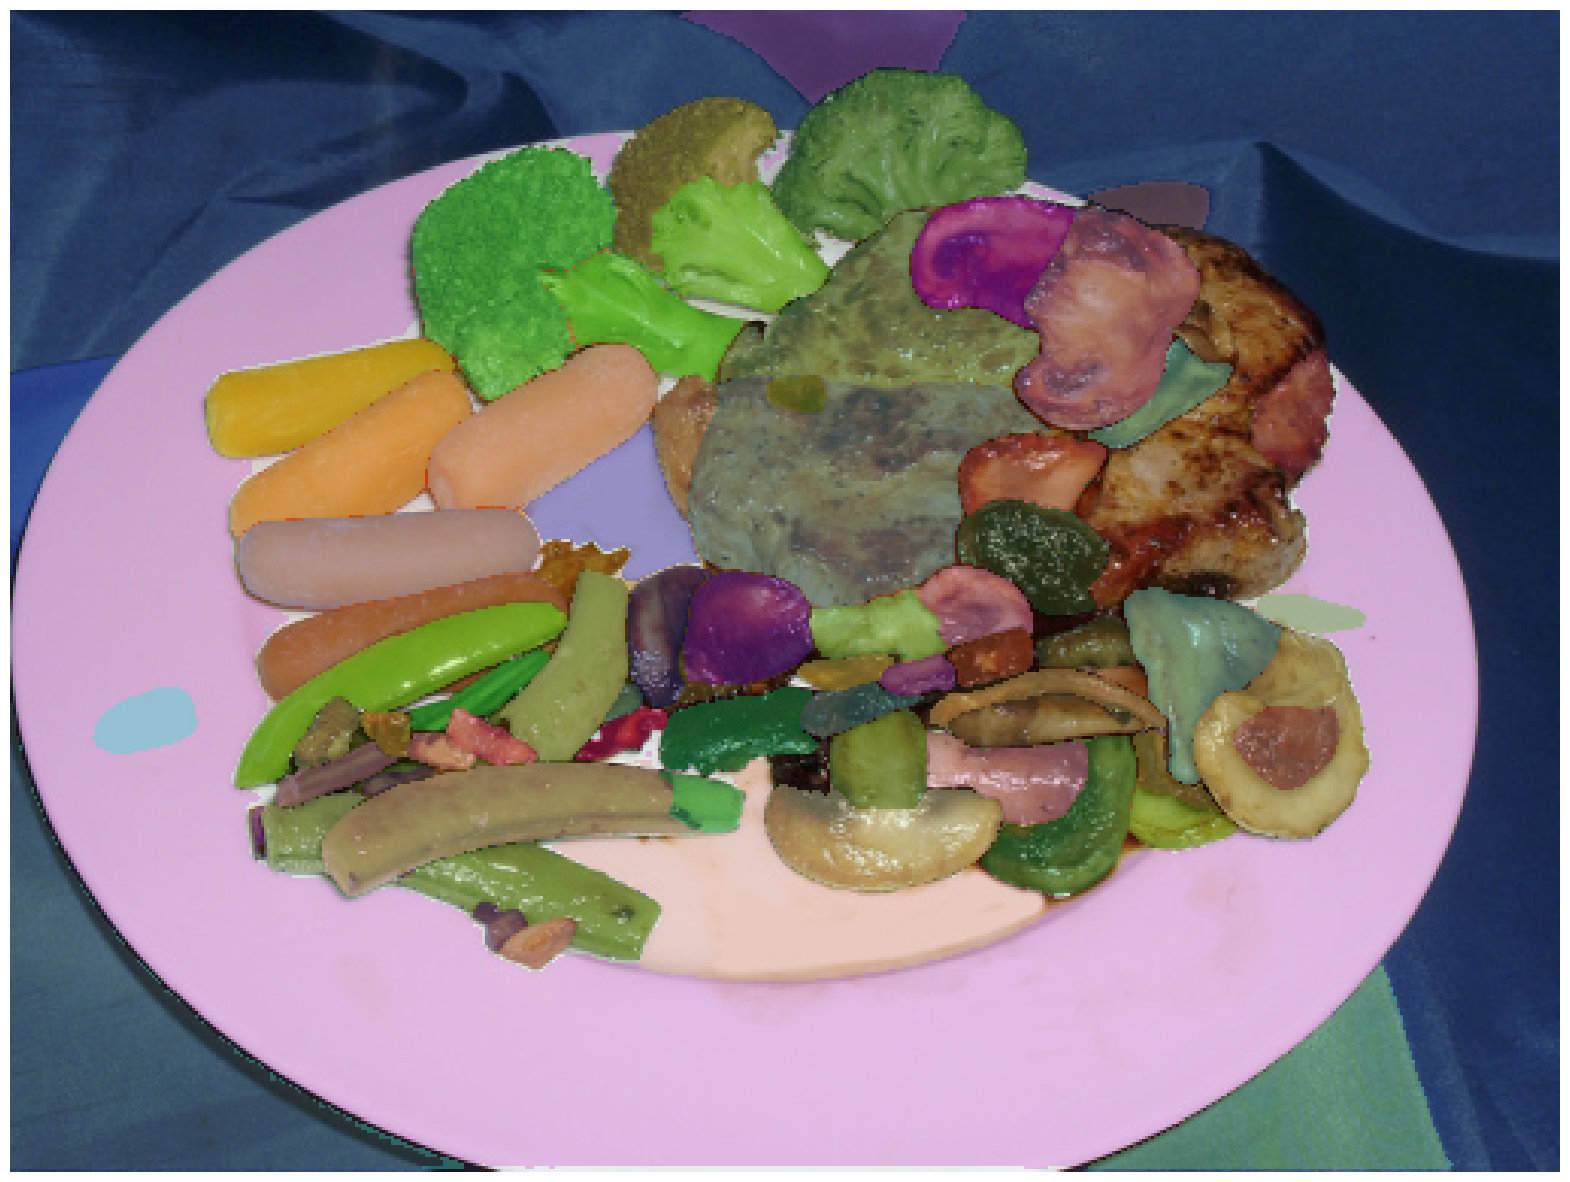

In [7]:
masks = mask_generator.generate(images[2])
plt.figure(figsize=(20, 20))
plt.imshow(images[2])
show_anns(masks)
plt.axis("off")
plt.show()

<img src="00000004_SAM.png" alt="00000004_SAM" />

In [8]:
images[2].shape

(384, 512, 3)

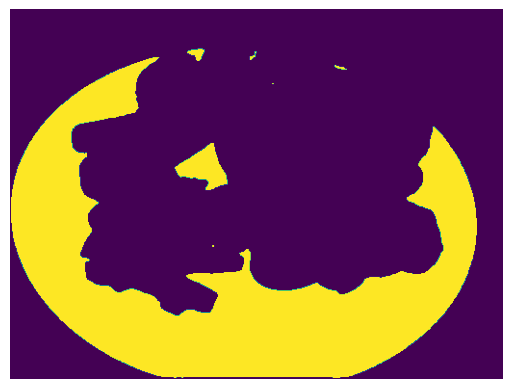

In [9]:
sorted_anns = sorted(masks, key=(lambda x: x["area"]), reverse=True)
img = np.zeros((sorted_anns[0]["segmentation"].shape[0], sorted_anns[0]["segmentation"].shape[1]))
m = sorted_anns[0]["segmentation"]
img[m] = 1
plt.axis("off")
plt.imshow(img)
plt.show()

In [10]:
mask = cv2.bitwise_and(images[2], images[2], mask=img.astype("uint8"))

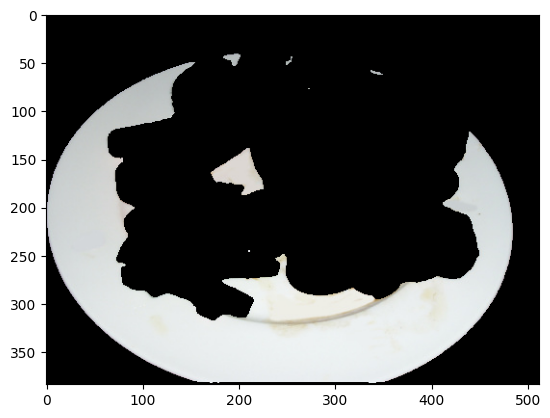

In [11]:
plt.imshow(mask)
plt.show()

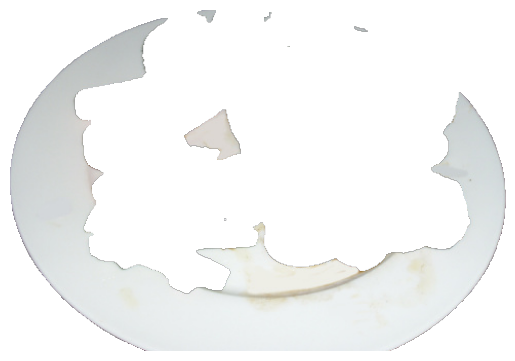

In [12]:
tmp = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
_, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
b, g, r = cv2.split(mask)
rgba = [b, g, r, alpha]
masked_img = cv2.merge(rgba, 4)
contours, _ = cv2.findContours(cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY),
                               cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
top_left_x = top_left_y = 999
right_bottom_x = right_bottom_y = 0
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if top_left_x >= x:
        top_left_x = x
    if top_left_y >= y:
        top_left_y = y
    if right_bottom_x <= x + w:
        right_bottom_x = x + w
    if right_bottom_y <= y + h:
        right_bottom_y = y + h
cropped_img = masked_img[top_left_y:right_bottom_y, top_left_x:right_bottom_x]
plt.axis("off")
plt.imshow(cropped_img)
plt.show()